In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

![CRISP_DM](crisp_dm2.png)

In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format


df_analyse=pd.read_csv(r'C:\Users\aditya\Downloads\COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True)

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3
...,...,...,...,...,...,...
873,2022-06-13,17664043,85666440,12478994,26915085,18239056
874,2022-06-14,17703887,85758512,12515127,27007429,18248479
875,2022-06-15,17736696,85941290,12515127,27096571,18256457
876,2022-06-16,17773764,86057735,12515127,27124689,18263643


In [3]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [4]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

In [5]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

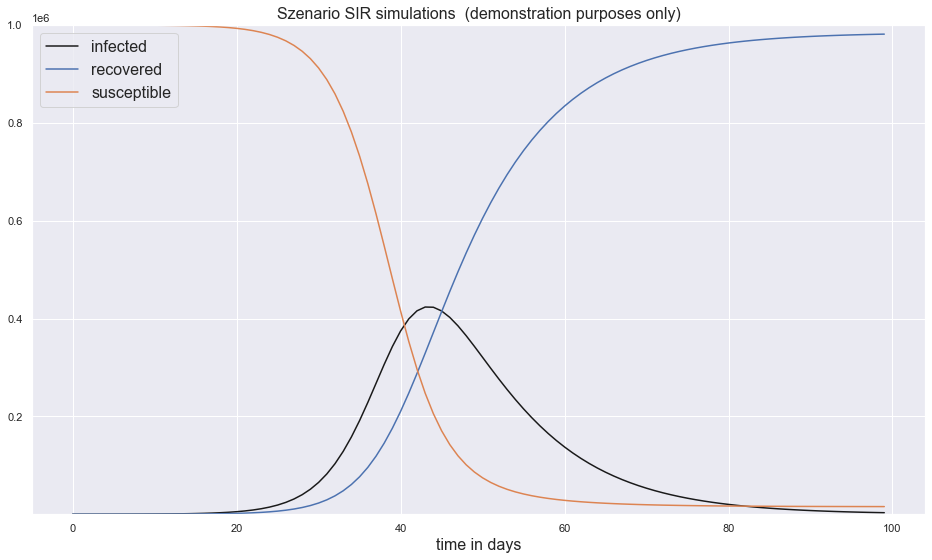

In [6]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

In [7]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [8]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [9]:
## fit the data set ydata, here the simulative data set of the infected curve

ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [10]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

C:\Users\aditya\AppData\Local\Temp/ipykernel_19172/649699423.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
C:\Users\aditya\AppData\Local\Temp/ipykernel_19172/649699423.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\aditya\AppData\Local\Temp/ipykernel_19172/649699423.py:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\aditya\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00087012 0.00074077]  start infect: 27.299823600000003
Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044


$N(t) = N_0^2(t/T)$

In [11]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

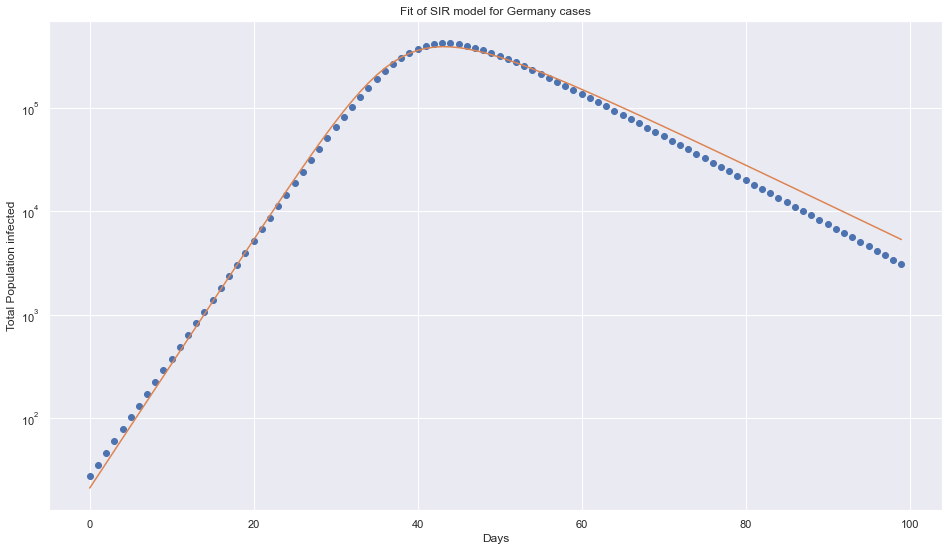

Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044
Basic Reproduction Number R0  3.8812910431198726
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible


In [12]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Total Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible")

In [13]:
## slice out some true data of a country

ydata = np.array(df_analyse.Germany[40:150])
t=np.arange(len(ydata))

In [14]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0=10000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

start infected: 150
cumulative sum of invected after period 188534
Number of days 110
N0 10000000


In [15]:
## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

plot_fitted={}

plot_fitted['Germany'] = fitted

standard deviation errors :  [0.01236702 0.0121435 ]  start infect: 150
Optimal parameters: beta = 0.502585456464543  and gamma =  0.39714281267326945


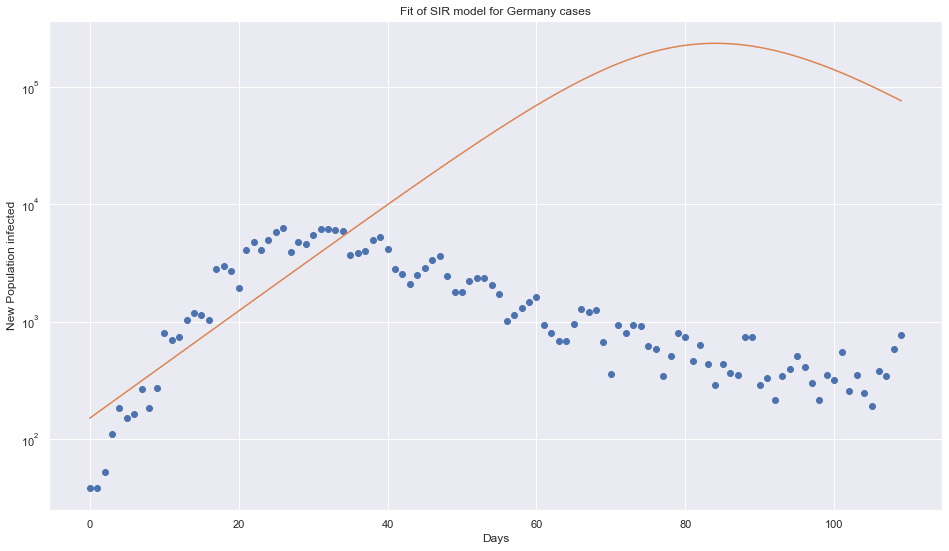

Optimal parameters: beta = 0.502585456464543  and gamma =  0.39714281267326945
Basic Reproduction Number R0  1.2655030896354695
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [16]:
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")


start infected: 55
cumulative sum of invected after period 2219506
Number of days 110
N0 10000000


C:\Users\aditya\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\aditya\AppData\Local\Temp/ipykernel_19172/649699423.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
C:\Users\aditya\AppData\Local\Temp/ipykernel_19172/649699423.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\aditya\AppData\Local\Temp/ipykernel_19172/649699423.py:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\aditya\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00414124 0.00386715]  start infect: 55
Optimal parameters: beta = 0.23290972580321462  and gamma =  0.09343386690427008


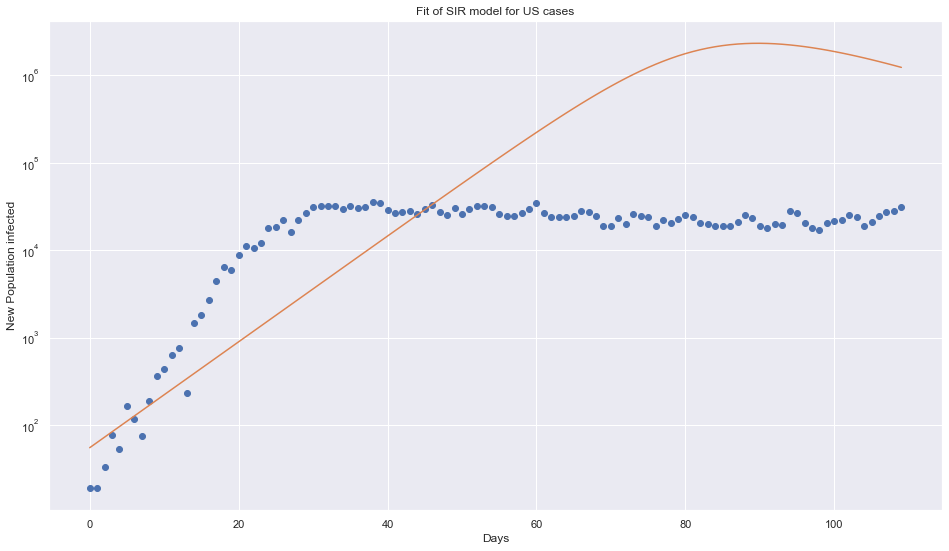

Optimal parameters: beta = 0.23290972580321462  and gamma =  0.09343386690427008
Basic Reproduction Number R0  2.4927762653968704
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [17]:
ydata = np.array(df_analyse.US[40:150])
t=np.arange(len(ydata))

N0=10000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

plot_fitted['US'] = fitted


# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for US cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")


start infected: 2036
cumulative sum of invected after period 238011
Number of days 110
N0 10000000
standard deviation errors :  [0.0060185  0.00574101]  start infect: 2036
Optimal parameters: beta = 0.3451379817977155  and gamma =  0.2659438674223654


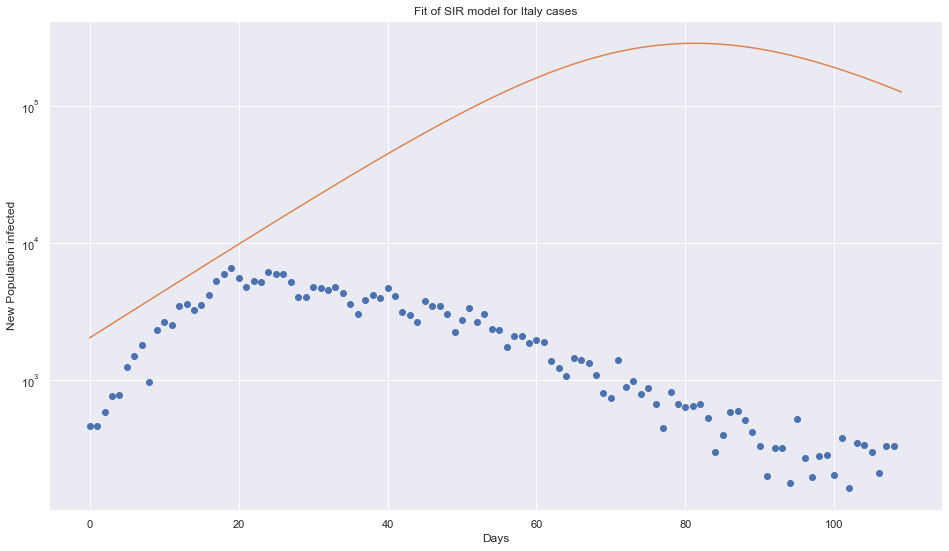

Optimal parameters: beta = 0.3451379817977155  and gamma =  0.2659438674223654
Basic Reproduction Number R0  1.2977850745081327
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [18]:
ydata = np.array(df_analyse.Italy[40:150])
t=np.arange(len(ydata))

N0=10000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

plot_fitted['Italy'] = fitted


# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Italy cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")


In [19]:
import pandas as pd
import numpy as np

import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

import os
fig3 = go.Figure()
app = dash.Dash()
app.layout = html.Div([
    
    dcc.Markdown('''
    #  Delivery 4 SIR_MODEL
    '''),
          
    html.Div([
        "Country Selection",
        dcc.Dropdown( id='country_drop_down3',
        options=[
            {'label': 'Germany', 'value': 'Germany'},
            {'label': 'US', 'value': 'US'}, 
            {'label': 'Italy', 'value': 'Italy'}, 
            ],
        value=['Germany Data','Italy'], # which are pre-selected
        multi=True),
         dcc.Graph(figure=fig3, id='main_window_slope3')
             ]),
     
])

C:\Users\aditya\AppData\Local\Temp/ipykernel_19172/3222582878.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\aditya\AppData\Local\Temp/ipykernel_19172/3222582878.py:7: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [21]:

@app.callback(
    Output('main_window_slope3', 'figure'),
    [Input('country_drop_down3', 'value')])

def update_figure(data_list):

    traces3 = [] 
    for each in data_list:
        
        #t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0])
        traces3.append(dict (   x=t,
                                y=plot_fitted[each],
                                mode='lines',
                                opacity=1,
                                line_width=2,
                                marker_size=4, 
                                name=each
                                                                                       
                               
                      )
        )     
        
        traces3.append(dict (   x=t,
                              y=np.ediff1d(np.array(df_analyse[each][40:150]), to_begin=np.array(df_analyse[each])[1]-np.array(df_analyse[each])[0]),
                                mode='markers',
                                opacity=1,
                                line_width=2,
                                marker_size=4, 
                                name="SIR Model "+each
                                                                                       
                               
                      )
        )     
        
    return {
            'data': traces3,
            'layout': dict (
                width=1100,
                height=600,
                xaxis_title="Time",
                yaxis_title="SIR Models",
                xaxis={'title':'Days',
                       'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=10,color="#7f7f7f"),
                        
                      },
                  yaxis={'type':"log",
                         'range':'[1.1,5.5]',
                        'title':'New Population Infected'
                      }
                         )
            }
if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
